**задача: классификация по тональности на  корпусе отзывов Google Play, используя пайплайн с Trainer**

Решите задачу классификации по тональности на подготовленном в тетрадке корпусе отзывов Google Play, используя пайплайн с Trainer от HuggingFace.

 #  data and modules

In [2]:
!pip install -q -U watermark

In [3]:
!pip install transformers > /dev/null

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.17.0



### mount gdrive

In [5]:
from transformers import Trainer, TrainingArguments
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
import transformers
from transformers import BertModel, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [ ]:
# !gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 76.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 149MB/s]


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [ ]:
# df = pd.read_csv("reviews.csv")

In [ ]:
# df.shape

(15746, 11)

In [ ]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


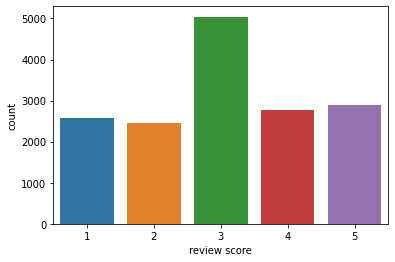

In [ ]:
# sns.countplot(df.score)
# plt.xlabel('review score');

In [ ]:
# def to_sentiment(rating):
#   rating = int(rating)
#   if rating <= 2:
#     return 0
#   elif rating == 3:
#     return 1
#   else: 
#     return 2

# df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


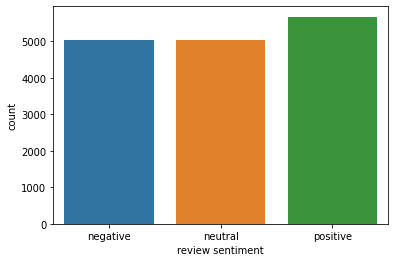

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

In [ ]:
# df.to_csv("/gdrive/My Drive/nnhw4/reviews.csv", index=False)

# load data!

In [8]:
# со сбалансированными данными
df = pd.read_csv("/gdrive/My Drive/nnhw4/reviews.csv")
class_names = ['negative', 'neutral', 'positive']

# 1 ST MODEL

обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) -- 2 балла

one of the smaller pre-trained BERT variant

беру его тк занимает меньше места и быстрее работает

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [9]:
PRE_TRAINED_MODEL_NAME = "prajjwal1/bert-tiny"

In [10]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

## dataset

Установим максимальную длину последовательности равной 160 как в семинаре



In [11]:
MAX_LEN = 160

targets must be called labels for trainer

In [12]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(target, dtype=torch.long)
    }

## train & test

Разделим данные на обучающую, тестовую и валидационную выборки 

In [13]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cuda', index=0)

In [15]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [16]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [17]:
train_dataset = GPReviewDataset(
    reviews=df_train.content.to_numpy(),
    targets=df_train.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

test_dataset = GPReviewDataset(
    reviews=df_test.content.to_numpy(),
    targets=df_test.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

val_dataset = GPReviewDataset(
    reviews=df_val.content.to_numpy(),
    targets=df_val.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## SentimentClassifier на основе BertModel

from seminar but with mods for trainer

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask, labels=None): # labels=None ?
    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    logits = self.out(self.drop(pooled_output))

    loss = None
    if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.n_classes), labels.view(-1)) #

    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## metrics

Опишем функцию для подсчета метрик, которые хотим увидеть при оценке модели (по умолчанию будет вычисляться только loss):

у precision_recall_fscore_support в параметре average выбираю

'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

потому что в датасете все-таки есть небольшой дисбаланс в сторону позитивного класса

In [18]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# training args (for all models)

In [19]:
training_args = TrainingArguments(
    output_dir='/gdrive/My Drive/nnhw4/results/',          # output directory
    num_train_epochs=2,                                    # total number of training epochs
    per_device_train_batch_size=8,                         # batch size per device during training
    per_device_eval_batch_size=8,                          # batch size for evaluation
    warmup_steps=500,                                      # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                                     # strength of weight decay
    logging_dir='/gdrive/My Drive/nnhw4/logs',             # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1", 
    do_train=True,
    overwrite_output_dir=False,
)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer_res = trainer.train()

***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3544


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.852200,0.770167,0.635324,0.639610,0.645794,0.635324
2,0.845800,0.731765,0.672173,0.666433,0.664603,0.672173


***** Running Evaluation *****
  Num examples = 787
  Batch size = 8
Saving model checkpoint to /gdrive/My Drive/nnhw4/results/checkpoint-1772
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 8
Saving model checkpoint to /gdrive/My Drive/nnhw4/results/checkpoint-3544
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /gdrive/My Drive/nnhw4/results/checkpoint-3544 (score: 0.6664329230535494).


In [ ]:
pd.DataFrame([trainer_res.metrics]).T

,0
train_runtime,133.851300
train_samples_per_second,211.742000
train_steps_per_second,26.477000
total_flos,0.000000
train_loss,0.894104
epoch,2.000000


## 1st model on test: metrics

In [ ]:
tester_result = trainer.predict(test_dataset=test_dataset)

***** Running Prediction *****
  Num examples = 788
  Batch size = 8


In [ ]:
pd.DataFrame([tester_result.metrics]).T

,0
test_loss,0.771179
test_accuracy,0.663706
test_f1,0.657815
test_precision,0.655980
test_recall,0.663706
test_runtime,1.756600
test_samples_per_second,448.584000
test_steps_per_second,56.358000


# 2nd model

измените модель, чтобы помимо выхода с пуллер-слоя использовался эмбеддинг cls-токена с последнего слоя. -- 3 балла

склеиваю  выход с пуллер слоя и эмбеддинг cls токена с посл слоя -> длина становится в 2 раза больше -> увеличиваю в linear слое hidden size в 2 раза

In [ ]:
class SentimentClassifierWithCLS(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size*2, n_classes)
  
  def forward(self, input_ids, attention_mask, labels=None):
    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    
    cls = last_hidden_state[:,0,:]
    stacked_layers = torch.hstack([cls, pooled_output])

    logits = self.out(self.drop(stacked_layers))

    loss = None
    if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.n_classes), labels.view(-1)) #

    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [ ]:
model = SentimentClassifierWithCLS(len(class_names))
model = model.to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/1ee037c9e1a220d5c814779ffe697080d1e6f5b16

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer_cls = trainer.train()

***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3544


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.917200,0.753572,0.626429,0.627483,0.628651,0.626429
2,0.863400,0.729234,0.665820,0.664590,0.663639,0.665820


***** Running Evaluation *****
  Num examples = 787
  Batch size = 8
Saving model checkpoint to /gdrive/My Drive/nnhw4/results/checkpoint-1772
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 8
Saving model checkpoint to /gdrive/My Drive/nnhw4/results/checkpoint-3544
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /gdrive/My Drive/nnhw4/results/checkpoint-3544 (score: 0.6645903700644462).


In [ ]:
pd.DataFrame([trainer_cls.metrics]).T

,0
train_runtime,129.677100
train_samples_per_second,218.558000
train_steps_per_second,27.329000
total_flos,0.000000
train_loss,0.883789
epoch,2.000000


## 2nd model on test: metrics

In [ ]:
tester_result_cls = trainer.predict(test_dataset=test_dataset)

***** Running Prediction *****
  Num examples = 788
  Batch size = 8


In [ ]:
pd.DataFrame([tester_result_cls.metrics]).T

,0
test_loss,0.775070
test_accuracy,0.653553
test_f1,0.653061
test_precision,0.652724
test_recall,0.653553
test_runtime,1.697700
test_samples_per_second,464.167000
test_steps_per_second,58.315000


# 3rd model

примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification) -- 2 балла

In [20]:
from transformers import BertForSequenceClassification, BertConfig

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = model.to(device)

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

переопределение конфига чтоб было 3 класса

In [21]:
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
config.num_labels = 3
model = BertForSequenceClassification(config) 
# model.parameters

In [22]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer_seq = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3544


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.853600,0.851903,0.601017,0.594889,0.597168,0.601017
2,0.769800,0.805520,0.641677,0.637631,0.636307,0.641677


***** Running Evaluation *****
  Num examples = 787
  Batch size = 8
Saving model checkpoint to /gdrive/My Drive/nnhw4/results/checkpoint-1772
Configuration saved in /gdrive/My Drive/nnhw4/results/checkpoint-1772/config.json
Model weights saved in /gdrive/My Drive/nnhw4/results/checkpoint-1772/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 787
  Batch size = 8
Saving model checkpoint to /gdrive/My Drive/nnhw4/results/checkpoint-3544
Configuration saved in /gdrive/My Drive/nnhw4/results/checkpoint-3544/config.json
Model weights saved in /gdrive/My Drive/nnhw4/results/checkpoint-3544/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /gdrive/My Drive/nnhw4/results/checkpoint-3544 (score: 0.6376306238536579).


In [23]:
pd.DataFrame([trainer_seq.metrics]).T

,0
train_runtime,1.401311e+02
train_samples_per_second,2.022530e+02
train_steps_per_second,2.529100e+01
total_flos,1.125605e+13
train_loss,9.073367e-01
epoch,2.000000e+00


## 3rd model on test: metrics

In [24]:
tester_result_seq = trainer.predict(test_dataset=test_dataset)

***** Running Prediction *****
  Num examples = 788
  Batch size = 8


In [25]:
pd.DataFrame([tester_result_seq.metrics]).T

,0
test_loss,0.827612
test_accuracy,0.620558
test_f1,0.615117
test_precision,0.612888
test_recall,0.620558
test_runtime,1.700300
test_samples_per_second,463.460000
test_steps_per_second,58.227000


# 4th model

*4. агрегируйте cls-токены для нескольких слоев, чтобы сделать предсказание класса -- 2 дополнительных балла

In [ ]:
# соберу все cls по hidden_states

In [ ]:
class SentimentClassifierWithManyCLS(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size*2, n_classes)
  
  def forward(self, input_ids, attention_mask, labels=None):
    _, pooled_output, hidden_states = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False,
      output_hidden_states=True)
    
    cls = torch.stack(hidden_states)[:,:,1,:].mean(axis=0)
    stacked_layers = torch.hstack([cls, pooled_output])

    logits = self.out(self.drop(stacked_layers))

    loss = None
    if labels is not None:
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.n_classes), labels.view(-1)) #

    output = (logits,)
    return ((loss,) + output) if loss is not None else output

In [ ]:
model = SentimentClassifierWithManyCLS(len(class_names))
model = model.to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/1ee037c9e1a220d5c814779ffe697080d1e6f5b16

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer4 = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3544


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.863500,0.755544,0.645489,0.645048,0.644725,0.645489
2,0.842200,0.728390,0.672173,0.669501,0.670383,0.672173


***** Running Evaluation *****
  Num examples = 787
  Batch size = 8
Saving model checkpoint to /gdrive/My Drive/nnhw4/results/checkpoint-1772
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 787
  Batch size = 8
Saving model checkpoint to /gdrive/My Drive/nnhw4/results/checkpoint-3544
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /gdrive/My Drive/nnhw4/results/checkpoint-3544 (score: 0.6695010567953409).


In [ ]:
pd.DataFrame([trainer4.metrics]).T

,0
train_runtime,85.263700
train_samples_per_second,332.404000
train_steps_per_second,41.565000
total_flos,0.000000
train_loss,0.887263
epoch,2.000000


## 4th model on test: metrics

In [ ]:
tester_result4 = trainer.predict(test_dataset=test_dataset)

***** Running Prediction *****
  Num examples = 788
  Batch size = 8


In [ ]:
pd.DataFrame([tester_result4.metrics]).T

,0
test_loss,0.771274
test_accuracy,0.648477
test_f1,0.646094
test_precision,0.645905
test_recall,0.648477
test_runtime,1.197700
test_samples_per_second,657.901000
test_steps_per_second,82.655000


# 3 ревью с разными сентиментами



беру модель показавшую лучшие результаты по f1 - 1st model

позитивные из тестовой выборки

In [35]:
rev = df_test[df_test.sentiment == 2].loc[14280].content
print(rev)

The app is good. I am using the pro version since years. It works well with Google calendar. Now I want to use my Outlook calendar as well. But I can not find the possibility to add an Outlook calendar there. Do you have any suggestions for it?


In [36]:
encoding = tokenizer.encode_plus(
  rev,
  max_length=MAX_LEN,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to(device)

In [37]:
model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

1

neutral

In [51]:
rev = df_test[df_test.sentiment == 1].loc[6704].content
print(rev)

Seems pretty neat but i miss one feature thst is very important for me: be able to just hit start/stop for tasks thst needs to be done for at least x minutes per day. i dont check or remember time when i start doing something.


In [52]:
encoding = tokenizer.encode_plus(
  rev,
  max_length=MAX_LEN,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to(device)

In [53]:
model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

1

negative

In [42]:
rev = df_test[df_test.sentiment == 0].loc[14775].content
print(rev)

This app sucks its slow and they make you pay to make checklists which is 
ridiculous


In [43]:
encoding = tokenizer.encode_plus(
  rev,
  max_length=MAX_LEN,
  add_special_tokens=True, 
  return_token_type_ids=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  
  truncation=True
).to(device)

In [44]:
model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'])[0].cpu().detach().numpy().argmax()

0

итог: на этих 3х примерах модель угадала negative  и neutral классы, но не определила positive класс, записав это ревью в нейтральные. вероятно из-за того, что в конце пользователь пишет о проблеме "But I can not find the possibility to add an Outlook calendar there. Do you have any suggestions for it?" 

# END